## Implementing the forward model (Convolution) with cupy

In this notebook we will

1.  Learn how to implement convolution using FFTs
2.  Learn how to manage FFT memory with cupy
3.  Purposely run out of memory and think through strategies to deal with high memory use 

In [9]:
from skimage.io import imread
from tnia.plotting.projections import show_xy_zy_max
import cupy as cp
import numpy as np
from tnia.deconvolution.pad import pad, unpad

mempool = cp.get_default_memory_pool()

total_gpu_memory = mempool

bpg=(1024**3)

available_gpu_memory = cp.cuda.Device(0).mem_info[0]
total_gpu_memory = cp.cuda.Device(0).mem_info[1]
print("Total GPU memory = {}".format(total_gpu_memory/bpg))
print("Available GPU memory = {}".format(available_gpu_memory/bpg))
print("At beginning, used = {}".format(mempool.used_bytes()/bpg))
    

Total GPU memory = 23.9993896484375
Available GPU memory = 22.7470703125
At beginning, used = 0.0


float32 (256, 256, 256)


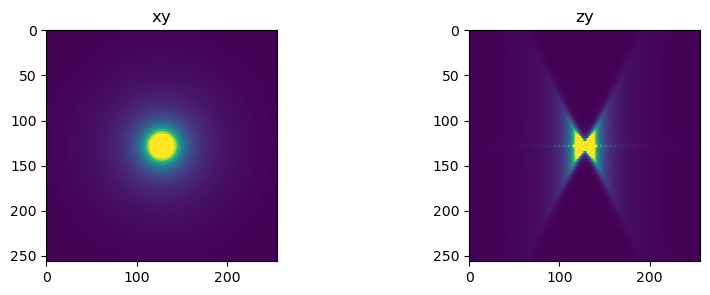

In [11]:

path_=r"D:\images\tnia-python-images\deconvolution\bead"

psf=imread(path_+"/PSF-Bead.tif").astype(np.float32)
psf=psf/psf.sum()

print(psf.dtype, psf.shape)

fig=show_xy_zy_max(psf, vmax=psf.max()/100)


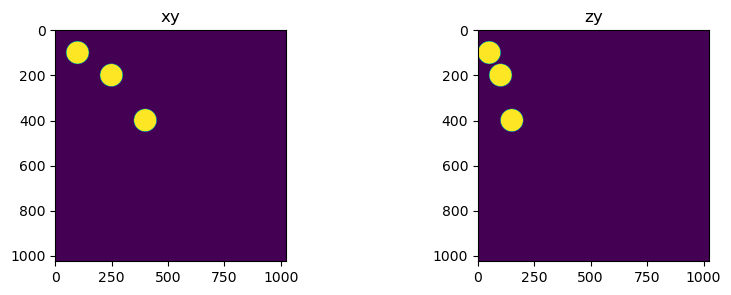

In [3]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

xdim=1024
ydim=1024
zdim=1024

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
size = [2*r, 2*r, 2*r]
sphere = rg.sphere(size, r).astype(np.float32)

x=100
y=100
z=50

add_small_to_large(phantom, sphere, 100, 100, 50)
add_small_to_large(phantom, sphere, 250, 200, 100)
add_small_to_large(phantom, sphere, 400, 400, 150)

fig = show_xy_zy_max(phantom)


In [4]:
phantom.dtype, psf.dtype, phantom.shape, psf.shape
psf, _ = pad(psf, phantom.shape, 'constant')

In [5]:

print("At beginning, used = {}".format(mempool.used_bytes()/bpg))
phantom_cp = cp.array(phantom)
print("After creating phantom, used = {}".format(mempool.used_bytes()/bpg))
psf_cp = cp.array(psf)
print("After creating psf, used = {}".format(mempool.used_bytes()/bpg))
psf_cp_shift = cp.fft.ifftshift(psf_cp)
print("After creating psf_shift, used = {}".format(mempool.used_bytes()/bpg))
otf_cp = cp.fft.rfftn(psf_cp_shift)
print("After creating otf, used = {}".format(mempool.used_bytes()/bpg))
phantom_cp_fft = cp.fft.rfftn(phantom_cp)
print("After creating phantom_fft, used = {}".format(mempool.used_bytes()/bpg))
temp = phantom_cp_fft * otf_cp
print("After creating temp, used = {}".format(mempool.used_bytes()/bpg))
convolved_cp = cp.fft.irfftn(temp)
print("After creating convolved_cp, used = {}".format(mempool.used_bytes()/bpg))
convolved = cp.asnumpy(convolved_cp)
print("After creating convolved, used = {}".format(mempool.used_bytes()/bpg))

fig = show_xy_zy_max(phantom)
fig = show_xy_zy_max(convolved)

At beginning, used = 0.0
After creating phantom, used = 4.0
After creating psf, used = 8.0
After creating psf_shift, used = 12.0
After creating otf, used = 20.015625


OutOfMemoryError: Out of memory allocating 4,303,355,904 bytes (allocated so far: 21,491,613,696 bytes).

In [ ]:
print("After free_all_blocks, used = {}".format(mempool.used_bytes()/bpg))
mempool.free_all_blocks()
print("After free_all_blocks, used = {}".format(mempool.used_bytes()/bpg))


After free_all_blocks, used = 20.015625
After free_all_blocks, used = 20.015625


In [11]:
try:
    # if phantom_cp defined, delete it
    if 'psf_cp' in locals():
        print("before psf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('psf_cp exists, deleting it')
        del psf_cp
        mempool.free_all_blocks()
        print("psf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'phantom_cp' in locals():
        print("before phantom_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('phantom_cp exists, deleting it')
        del phantom_cp
        mempool.free_all_blocks()
        print("phantom_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'psf_cp_shift' in locals():
        print("before psf_cp_shift deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('psf_cp_shift exists, deleting it')
        del psf_cp_shift
        mempool.free_all_blocks()
        print("psf_cp_shift deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'otf_cp' in locals():
        print("before otf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('otf_cp exists, deleting it')
        del otf_cp
        mempool.free_all_blocks()
        print("otf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'phantom_cp_fft' in locals():
        print("before phantom_cp_fft deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('phantom_cp_fft exists, deleting it')
        del phantom_cp_fft
        mempool.free_all_blocks()
        print("phantom_cp_fft deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'temp' in locals():
        print("before temp deleted, used = {}".format(mempool.used_bytes()/bpg)) 
        print('temp exists, deleting it')
        del temp
        mempool.free_all_blocks()
        print("temp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'convolved_cp' in locals():
        print("before convolved_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('convolved_cp exists, deleting it')
        del convolved_cp
        mempool.free_all_blocks()
        print("convolved_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
except Exception as e:
    print(e)

before psf_cp deleted, used = 20.015625
psf_cp exists, deleting it
psf_cp deleted, used = 16.015625

before phantom_cp deleted, used = 16.015625
phantom_cp exists, deleting it
phantom_cp deleted, used = 16.015625

before psf_cp_shift deleted, used = 16.015625
psf_cp_shift exists, deleting it
psf_cp_shift deleted, used = 12.015625

before otf_cp deleted, used = 12.015625
otf_cp exists, deleting it
otf_cp deleted, used = 8.0078125



In [8]:
try:
    # if phantom_cp defined, delete it
    if phantom_cp is not None:
        del phantom_cp
    if psf_cp is not None:
        del psf_cp
    if psf_cp_shift is not None:
        del psf_cp_shift
    if otf_cp is not None:
        del otf_cp
    if phantom_cp_fft is not None:
        del phantom_cp_fft
    if temp is not None:
        del temp
    if convolved_cp is not None:
        del convolved_cp
    if psf is not None:
        del psf
    if phantom is not None:
        del phantom
except:
    print('exception occurred deleting variable (likely variable not defined)')
mempool.free_all_blocks()
print("After del, used = {}".format(mempool.used_bytes()/bpg))

exception occurred deleting variable (likely variable not defined)
After del, used = 12.1416015625


In [7]:
print("After del, used = {}".format(mempool.used_bytes()/bpg))

 # explicitly clear the plan cache to avoid memory leak
cache = cp.fft.config.get_plan_cache()
cache.clear()

cp.get_default_memory_pool().free_all_blocks()
mempool.free_all_blocks()

print("After del, used = {}".format(mempool.used_bytes()/bpg))


After del, used = 8.0078125
After del, used = 8.0078125


In [5]:

print("At beginning, used = {}".format(mempool.used_bytes()/1024**3))
phantom_cp = cp.array(phantom)
print("After creating phantom, used = {}".format(mempool.used_bytes()/1024**3))
psf_cp = cp.array(psf)
print("After creating psf, used = {}".format(mempool.used_bytes()/1024**3))
psf_cp_shift = cp.fft.ifftshift(psf_cp)
print("After creating psf_shift, used = {}".format(mempool.used_bytes()/1024**3))
otf_cp = cp.fft.rfftn(psf_cp_shift)

print("After creating otf, used = {}".format(mempool.used_bytes()/1024**3))
del psf_cp
del psf_cp_shift
mempool.free_all_blocks()
print("After deleting psf, used = {}".format(mempool.used_bytes()/1024**3))


phantom_cp_fft = cp.fft.rfftn(phantom_cp)
print("After creating phantom_fft, used = {}".format(mempool.used_bytes()/1024**3))
temp = phantom_cp_fft * otf_cp
print("After creating temp, used = {}".format(mempool.used_bytes()/1024**3))
del phantom_cp
del phantom_cp_fft
del otf_cp
mempool.free_all_blocks()
print("After deleting phantom_cp_fft and otf_cp = {}".format(mempool.used_bytes()/1024**3))
convolved_cp = cp.fft.irfftn(temp)
print("After creating convolved_cp, used = {}".format(mempool.used_bytes()/1024**3))
convolved = cp.asnumpy(convolved_cp)
print("After creating convolved, used = {}".format(mempool.used_bytes()/1024**3))



At beginning, used = 0.0
After creating phantom, used = 4.0
After creating psf, used = 8.0
After creating psf_shift, used = 12.0
After creating otf, used = 20.015625
After deleting psf, used = 12.015625
After creating phantom_fft, used = 16.0234375
After creating temp, used = 20.03125
After deleting phantom_cp_fft and otf_cp = 8.015625
After creating convolved_cp, used = 16.0234375
After creating convolved, used = 16.0234375


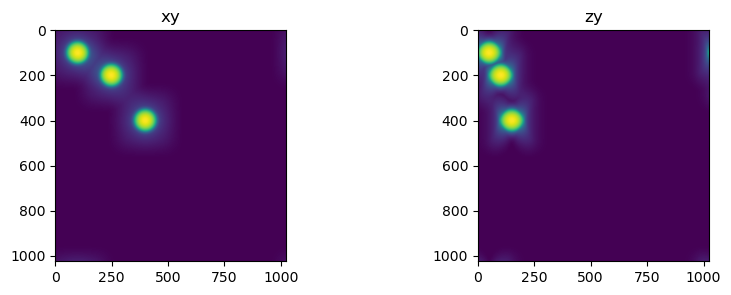

In [7]:
fig = show_xy_zy_max(convolved)